---
layout: default
title: "Deep Learning - RNN - Sequence to sequence models"
categories: deeplearning
permalink: /ML46/
order: 46
comments: true
---

In [1]:
%pylab --no-import-all inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
plt.rcParams["mathtext.fontset"] = "cm"
from mpl_flow import Flow

Populating the interactive namespace from numpy and matplotlib


# Sequence to sequence models
Sequence to sequence models are RNN algorithms that take sequences as input and produce sequences as output. They are employed in many fields from machine translation to speech recognition.

Machine translation is the perfect example of the reason why sequence to sequence models have been developed. Almost all the examples seen so far map an input sequence to a single output. In machine translation we want to translate a sentence from a language to a second sequence in another. 

## Basic seq-to-seq model
Suppose we have a sentence in French that we want to map to its English translation:

$$
\begin{split}
&\begin{array}
&x^{\langle 1 \rangle} & x^{\langle 2 \rangle} & x^{\langle 3 \rangle} & x^{\langle 4 \rangle} & x^{\langle 5 \rangle} \\
\text{Jane} & \text{visite} & \text{l'Afrique} & \text{en} & \text{septembre}
\end{array}\\ \\
&\begin{array}
&\text{Jane} & \text{is} & \text{visiting} & \text{Africa} & \text{in} & \text{September} \\
y^{\langle 1 \rangle} & y^{\langle 2 \rangle} & y^{\langle 3 \rangle} & y^{\langle 4 \rangle} & y^{\langle 5 \rangle} & y^{\langle 6 \rangle} 
\end{array}
\end{split}
$$

In order to map such input sequences to output sequences, [Sutskever et.al. 2014](https://arxiv.org/abs/1409.3215) and [Cho et.al.2014](https://arxiv.org/abs/1406.1078) developed RNN based seq-to-seq models. These models are made of an **encoder** network and a **decoder** network. The encoder processes the input sequence and then feeds it to the decoder, which produces the output sequence (<a href="#fig:seq2seqbasic">figure below</a>).

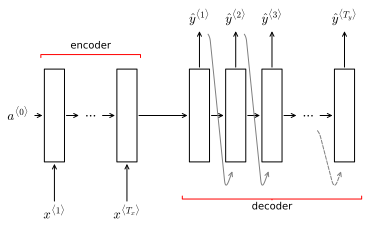

In [2]:
f = Flow(bbox=dict(boxstyle='square'))
for i in range(1, 9):
    d=1
    lbl = i if i < 5 else 'T_x'

    if i not in [2,7]:
        if i == 4:
            d=2
        f.node(f'a{i}', label='\n'*5+' '*3, fontsize=13, startpoint=f'a{i-1}', distance=d)
    else:
        f.node(f'a{i}', label='$\\cdots$', startpoint=f'a{i-1}', fontsize=13, bbox=dict(ec='none'))

    if i < 4 and i != 2:
        if i == 3:
            lbl = 'T_x'
        f.node(f'x{i}', label=f'$x^{{\\langle {lbl} \\rangle}}$', startpoint=f'a{i}',
               travel='s', fontsize=13, 
               edge_kwargs=dict(arrowprops=dict(arrowstyle='->')), bbox=dict(ec='none')) 

    if i >= 4 and i != 7:
        if i == 8:
            lbl = 'T_y'
        else:
            lbl = i - 3

        f.node(f'y{i}', label=f'$\\hat{{y}}^{{\\langle {lbl} \\rangle}}$', startpoint=f'a{i}', travel='n', fontsize=13,
               bbox=dict(ec='none'))
    
    if i > 4 and i < 7:
        f.edge(f'y{i-1}', f'a{i}', headport='s', tailport='s', 
           arrowprops=dict(connectionstyle='arc,angleA=-110,angleB=-10,armA=30,armB=10,rad=10', 
                           shrinkA=10, shrinkB=10, ec='gray'))
    if i == 8:
        f.edge(f'a{i-1}', f'a{i}', headport='s', tailport='s', 
           arrowprops=dict(connectionstyle='arc,angleA=-110,angleB=-10,armA=30,armB=10,rad=10', 
                           shrinkA=10, shrinkB=10, ec='gray', ls='--'))

f.node(startpoint='a1', label='$a^{\\langle 0 \\rangle}$', travel='w', fontsize=13, bbox=dict(ec='none'),
       edge_kwargs=dict(arrowprops=dict(arrowstyle='->')))

encoder_bbox = f.nodes['a2'].annotation.get_bbox_patch()
decoder_bbox = f.nodes['a6'].annotation.get_bbox_patch()
plt.annotate('encoder', (0.5, 3.5), (0.5, 3.8) , xycoords=encoder_bbox, textcoords=encoder_bbox, ha='center', 
             arrowprops=dict(arrowstyle='-[,widthB=5,lengthB=0.3,angleB=0', ec='r'))
plt.annotate('decoder', (0.5, -0.4), (0.5, -0.43) , xycoords=decoder_bbox, textcoords=decoder_bbox, ha='center', va='top',
             arrowprops=dict(arrowstyle='-[,widthB=9,lengthB=0.3,angleB=0', ec='r'));

<i id="fig:seq2seqbasic">A basic sequence to sequence RNN architecture with an encoder and a decoder. The encoder process the input sequence and feeds it to the decoder, which produces th output sequence</i>

The encoder and decoder are two separate networks that serve separate purposes. The task of the encoder is to produce a standard encoding (or we could say an embedding) of an input, while the task of the decoder is to interpret map the encoding to a sequence. 

To further sustain this point, the decoder can also be a convolutional network processing an image. In **image captioning** tasks in fact the ALEX-net, once the final sofmtax layer is removed, plays the role of the decoder network producing a 4096-dimensional encoding of an image, which is then fed to a decoder that produces a caption for the image. 

## Selecting the most likely translation
The decoder network in <a href="#fig:seq2seqbasic">the figure above</a> is a language model (<a href="page:ML44">ML-44</a>) in that it outputs the probability of the translated sentence 

$$P \left(y^{\langle 1 \rangle}, \dots, y^{\langle T_y \rangle} \right)$$

However, differently from a language model, its input is not a 0-padded vector $a^{\langle 0 \rangle}$ but it is instead the encoding produced by the encoder network. Thus, this language model outputs the conditional probability of the translation, given a certain input sentence $x$

$$
\begin{equation}
P \left (y^{\langle 1 \rangle}, \dots, y^{\langle T_y \rangle} \vert x \right )
\end{equation} \label{eq:transl} \tag{1}
$$

Each, input sentence might have different output sentences, each with its own probability associated. For example for the input french sentence:

```
Jane visite l'Afrique en septmebre
```

We could have the following sentences:

```
Jane is visiting Africa in September

Jane is going to be visiting Africa in September

In September, Jane will visit Africa

Her African friend welcomed Jane in September
```

So $\eqref{eq:transl}$ denotes a distribution of probabilities associated to different sentences. When feeding the input sentence to the machine translation algorithm we don't want to sample randomly from the output distribution since, while all sentences are strictly speaking correct, we can easily say that some are better translations than others in most contexts. Instead we want to select the **most likely translation**.

$$
\begin{equation}
\underset{y^{\langle 1 \rangle}, \dots, y^{\langle T_y \rangle}}{\arg \max} P \left (y^{\langle 1 \rangle}, \dots, y^{\langle T_y \rangle} \vert x \right )
\end{equation} \label{eq:mostliktransl} \tag{2}
$$

### Greedy Search
One possible, suboptimal, to select the most likely translation is to perform a **greedy search**. In a greedy search we would proceed to iteratively select the most likely element in the sequence (next word in the sentence) until completion.

However, we can see how this approach is suboptimal by looking at the following example. Given the two translations

```
Jane is visiting Africa in September

Jane is going to be visiting Africa in September
```

Where the first is better (more likely) than the second, a greedy search would probably select the second since the words `Jane is going` are very common english words and are more likely than `Jane is visiting`.

### Approximate Search
Instead of maximizing the probability $\eqref{eq:transl}$ by selecting one word at the time, we would like to select the group of words that, together, maximizes that probability.

However to explore the translation sentence space exahustively would the computationally impossible. In fact, given a vocabulary of 10000 words and only considering sentences of 10 words we would have $10^{10000}$ possible sentences to test.

For this reason **approximate search** algorithms are used that find near-optimal solutions quickly. One of the most common approximate search algorithsm is called **Beam search**

## Beam Search